In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/30-days-of-ml/sample_submission.csv
/kaggle/input/30-days-of-ml/train.csv
/kaggle/input/30-days-of-ml/test.csv


# Improvements form v2
    - Tune hyperparameters for XGBRegressor

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error

In [3]:
train_data = pd.read_csv('/kaggle/input/30-days-of-ml/train.csv')
test_data = pd.read_csv('/kaggle/input/30-days-of-ml/test.csv')

In [4]:
train_full = train_data.copy()
test_full = test_data.copy()

In [5]:
y = train_full['target']
X = train_full.drop('target', axis = 1)

In [6]:
X.drop('cat9', axis = 1, inplace = True)
test_full.drop('cat9', axis = 1, inplace = True)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.7, random_state = 0)

In [8]:
categories = [col for col in X_train.columns if X_train[col].dtype == 'object']

In [9]:
encoder = OrdinalEncoder()

enc_X_train = X_train.copy()
enc_X_valid = X_valid.copy()

enc_X_train[categories] = encoder.fit_transform(X_train[categories])
enc_X_valid[categories] = encoder.transform(X_valid[categories])
test_full[categories] = encoder.transform(test_full[categories])

In [10]:
results = {}
n_estimators = 5000
n_jobs = 4
learning_rate = [0.3, 0.1, 0.03, 0.01]

scores = []

for i in learning_rate:
    start = time.time()
    model = XGBRegressor(n_estimators = n_estimators, learning_rate = i, n_jobs = n_jobs, objective = 'reg:squarederror')
    model.fit(enc_X_train, y_train)
    predictions = model.predict(enc_X_valid)
    score = mean_squared_error(y_valid, predictions)
    end = time.time()
    
    print('Time to run: ', (end - start)/60, ' minutes')
    
    scores.append(score)
    
    results[score] = i

Time to run:  38.206513079007465  minutes
Time to run:  38.35458699862162  minutes
Time to run:  38.35308198531469  minutes
Time to run:  38.54996733665466  minutes


In [11]:
results

{0.6028457986593075: 0.3,
 0.5441942909981574: 0.1,
 0.5257557188363617: 0.03,
 0.5214485068721811: 0.01}

Text(0, 0.5, 'Score')

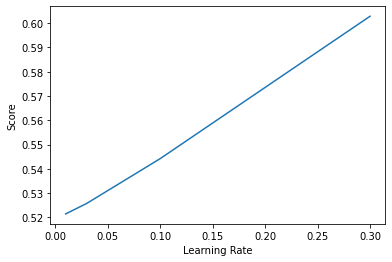

In [12]:
plt.plot(learning_rate, scores)
plt.xlabel('Learning Rate')
plt.ylabel('Score')

In [13]:
model = XGBRegressor(n_estimators = 5000, learning_rate = 0.01, n_jobs = n_jobs, objective = 'reg:squarederror')
model.fit(enc_X_train, y_train)
predictions = model.predict(enc_X_valid)
score = mean_squared_error(y_valid, predictions)
score

0.5214485068721811

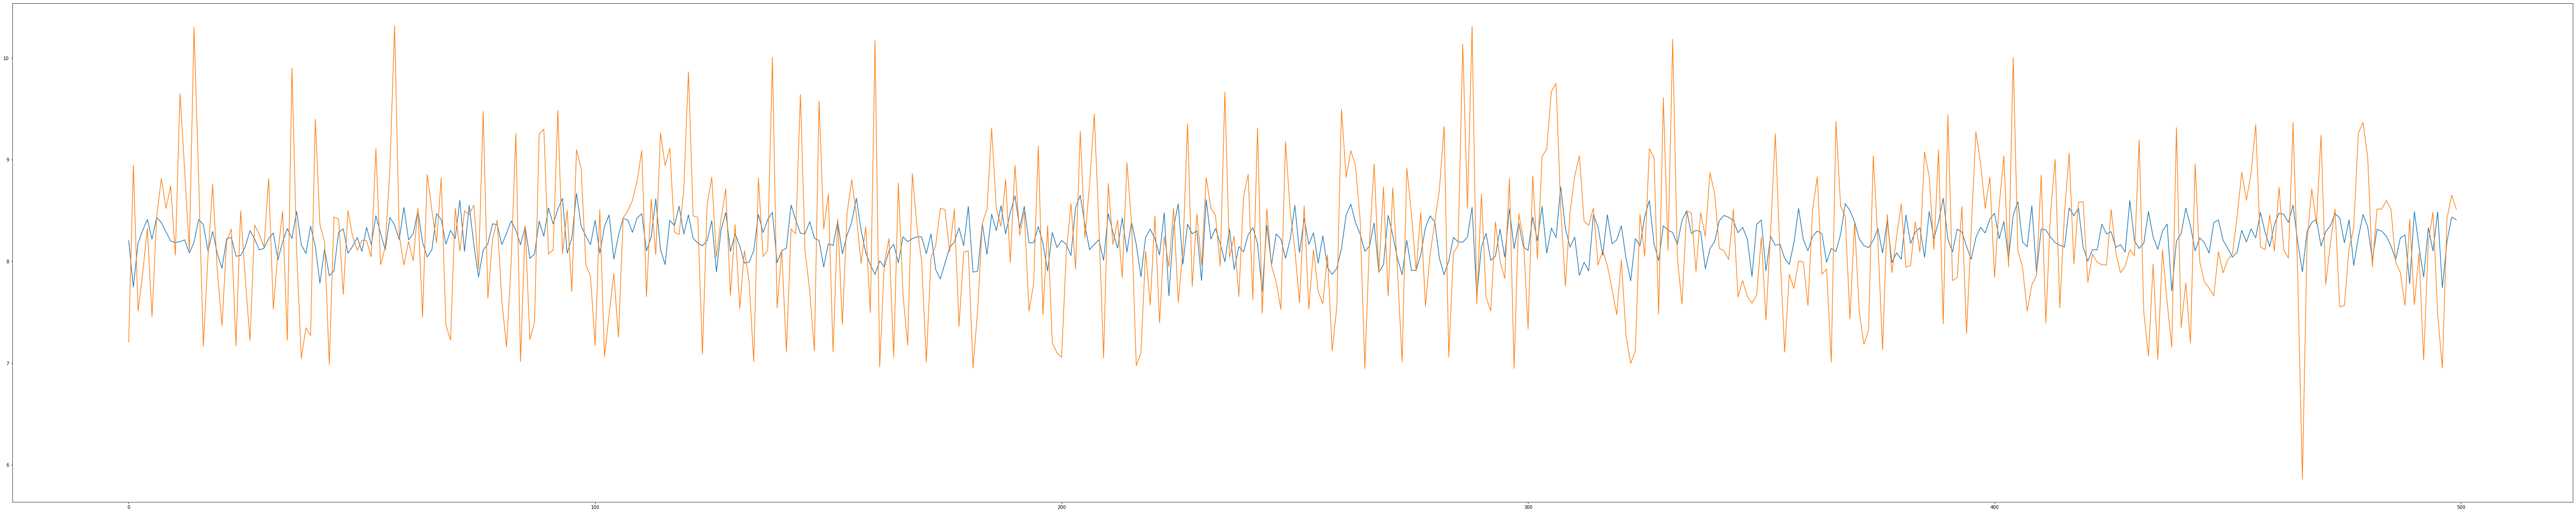

In [14]:
fig, ax = plt.subplots(figsize = (100,20))
x = range(len(predictions[:500]))
ax.plot(x, predictions[:500], label = 'Predicted')
ax.plot(x, y_valid[:500], label = 'Orignal')
plt.show()

In [15]:
final_preds = model.predict(test_full)

In [16]:
output = pd.DataFrame({
    'Id': test_full['id'], 
    'Target': final_preds}
)

In [17]:
output.to_csv('my_submission.csv', index = False)